# Variational AutoEncoder

## Loading Modules

In [1]:
%matplotlib inline

import os
import models
import numpy as np
import tensorflow as tf
import matplotlib as mpl

from tqdm import tqdm
from matplotlib import pyplot as plt
from matplotlib import gridspec as grid

from includes.config import Config
from includes.utils import load_data, Dataset

In [2]:
mpl.rc_file_defaults()

In [3]:
tf.logging.set_verbosity(tf.logging.ERROR)

In [4]:
xav_init = tf.contrib.layers.xavier_initializer()

## Loading Data and Setting Parameters

In [5]:
datagroup = "mnist"
dataset = "binary"

In [6]:
config = Config(datagroup)

train_data, test_data = load_data(datagroup, dataset=dataset)

train_data = Dataset(train_data, batch_size=config.batch_size)
test_data = Dataset(test_data, batch_size=config.batch_size)

Extracting data/mnist/train-images-idx3-ubyte.gz
Extracting data/mnist/train-labels-idx1-ubyte.gz
Extracting data/mnist/t10k-images-idx3-ubyte.gz
Extracting data/mnist/t10k-labels-idx1-ubyte.gz


## Visualizing the Data

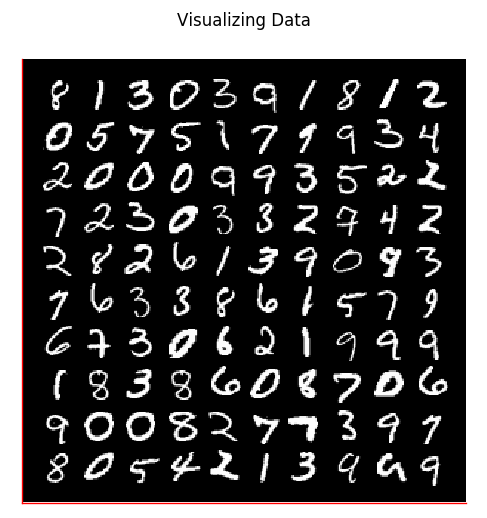

In [7]:
if datagroup == "spiral":
    plt.scatter(train_data.data[:, 0], train_data.data[:, 1], s=0.5)
elif datagroup == "mnist":
    images = train_data.data[np.random.choice(len(train_data), 100)]
    
    images = images.reshape((100, 28, 28))
    images = np.concatenate(images, axis=1)
    images = np.array([images[:, x:x+280] for x in range(0, 2800, 280)])
    images = np.concatenate(images, axis=0)
    images = np.concatenate(
        [np.zeros((280, 10)), images, np.zeros((280, 10))], axis=1
    )
    images = np.concatenate(
        [np.zeros((10, 300)), images, np.zeros((10, 300))], axis=0
    )

    plt.imshow(images, cmap='gray')
    plt.xticks([])
    plt.yticks([])
    
plt.title("Visualizing Data")
plt.show()

## Plotting Functions

In [8]:
def regeneration_plot():
    gs = grid.GridSpec(1, 2)

    ax1 = plt.subplot(gs[0])
    ax2 = plt.subplot(gs[1])

    def reshape(images):
        images = images.reshape((100, 28, 28))
        images = np.concatenate(images, axis=1)
        images = np.array([images[:, x:x+280]
                           for x in range(0, 2800, 280)])
        images = np.concatenate(images, axis=0)
        images = np.concatenate(
            [np.zeros((280, 10)), images, np.zeros((280, 10))], axis=1
        )
        images = np.concatenate(
            [np.zeros((10, 300)), images, np.zeros((10, 300))], axis=0
        )

        return images

    eps = vae.sample_reparametrization_variables(100, is_training=False)["Z"]

    orig_X = test_data.data[:100]
    recn_X = sess.run(
        vae.reconstructed_X, feed_dict={
            vae.X: orig_X,
            vae.epsilon: eps
        }
    )

    ax1.imshow(reshape(orig_X), cmap="Greys_r")
    ax2.imshow(reshape(recn_X), cmap="Greys_r")

    ax2.spines['left'].set_visible(False)
    ax2.spines['bottom'].set_visible(False)
    ax1.spines['left'].set_visible(False)
    ax1.spines['bottom'].set_visible(False)

    ax1.get_xaxis().set_visible(False)
    ax1.get_yaxis().set_visible(False)
    ax2.get_xaxis().set_visible(False)
    ax2.get_yaxis().set_visible(False)

    plt.tight_layout()
    plt.savefig("plots/regenerated.png", transparent=True)

In [14]:
def sample_plot():
    figure = np.zeros((280, 280))

    for i in range(10):
        for j in range(10):
            eps = vae.sample_reparametrization_variables(
                1, is_training=False)["Z"]
            print sess.run(vae.decoded_X, feed_dict={vae.Z: eps})
            out = sess.run(vae.reconstructed_X, feed_dict={vae.Z: eps})

            figure[i * 28: (i + 1) * 28, j * 28: (j + 1) *
                   28] = out.reshape((28, 28)) * 255

    ax = plt.axes()
    ax.imshow(figure, cmap="Greys_r")

    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    plt.tight_layout()
    plt.savefig("plots/sampled.png", transparent=True)

    plt.close()

## Defining the Model

In [10]:
vae = models.DiscreteVAE("discrete_vae", 784, 50, 10, activation=tf.nn.relu,
                         initializer=tf.contrib.layers.xavier_initializer)
vae.build_graph([500, 500, 2000], [2000, 500, 500])
vae.define_train_step(0.002, train_data.epoch_len * 10)

## Initializing Session

In [11]:
sess = tf.Session()
tf.global_variables_initializer().run(session=sess)

## Training

In [ ]:
with tqdm(range(100), postfix={"loss": "inf"}) as bar:
    for epoch in bar:
        if epoch % 5 == 0:
            sample_plot()
            regeneration_plot()

        bar.set_postfix({"loss": "%.4f" % vae.train_op(sess, train_data)})

sample_plot()
regeneration_plot()

In [15]:
sample_plot()

[[ 8.32174867e-02  2.04606205e-01  8.52805972e-02 -1.62350997e-01
  -2.06211239e-01  3.48795027e-01  3.08243185e-03 -3.73658687e-02
  -1.80837244e-01 -1.21125862e-01 -7.07845539e-02  8.01472217e-02
  -4.45178568e-01 -3.84939089e-02 -2.43967175e-01  2.03644335e-01
  -1.84293672e-01 -4.10349309e-01  2.69255698e-01 -3.18408087e-02
   2.65754104e-01 -2.82614917e-01  7.50070065e-02 -3.25029165e-01
  -2.62102842e-01 -2.01020271e-01 -2.52526462e-01 -1.63739175e-01
  -1.83255091e-01  1.46957204e-01 -8.76033008e-02  2.03764677e-01
   2.24790677e-01  1.52290180e-01 -1.42746508e-01  7.84646273e-02
  -2.32626975e-01 -2.87612267e-02  5.19511253e-02  2.37901017e-01
  -1.03444710e-01 -2.44062394e-02  1.88429028e-01  1.15525305e-01
   1.51987404e-01  1.27847493e-01  1.26899451e-01  1.82220221e-01
   8.69223252e-02 -3.25698048e-01  2.46230960e-01 -7.15085119e-02
   8.49835724e-02  1.04336105e-01  7.68079311e-02 -1.74435914e-01
  -9.65181887e-02  1.48476765e-01 -1.34804696e-02  8.12517107e-02
   2.61409

[[ 1.24103926e-01  2.80764550e-01 -4.59045395e-02 -2.07817107e-02
  -3.39619458e-01  4.03921664e-01  6.23516738e-02  6.83161169e-02
  -5.66707402e-02 -1.23214349e-02  7.52693191e-02 -3.16920653e-02
  -3.90826702e-01 -5.60790077e-02 -4.34391737e-01  1.04593113e-01
  -1.23845279e-01 -3.86332273e-01  2.27343038e-01 -4.35336083e-02
   1.26839727e-01 -2.20462173e-01  3.21494222e-01 -3.01552415e-01
  -1.09538287e-01 -1.07044257e-01 -1.76690087e-01 -2.86098778e-01
  -1.71876356e-01  9.85651389e-02 -2.02520877e-01  2.75105476e-01
   3.18146467e-01  2.35455915e-01 -1.07181437e-01 -4.77432385e-02
  -2.99894243e-01 -1.62428573e-01  2.24190533e-01  1.71704054e-01
  -1.21929988e-01  1.51906088e-02  3.80250961e-01  1.34234190e-01
   1.64951548e-01  1.04309723e-01  9.73153859e-02  2.04767838e-01
   1.26813084e-01 -4.50327963e-01 -3.88479233e-02 -1.41197354e-01
  -1.51188001e-01  2.80629814e-01  1.76733911e-01 -8.54646862e-02
  -7.87964314e-02 -6.25399426e-02  7.88644701e-03 -4.64746803e-02
   1.82776

[[-9.93692726e-02  2.99724728e-01  7.15745986e-02 -5.21156788e-02
  -2.33042985e-01  4.27059025e-01 -2.96318382e-02 -1.09555714e-01
  -6.08044416e-02  1.06266528e-01 -1.18518867e-01  8.25810060e-02
  -3.87049377e-01 -1.73958391e-01 -2.89095521e-01  1.48160204e-01
   8.60475898e-02 -2.28864715e-01  1.47408113e-01 -1.69201910e-01
   2.35453442e-01 -2.24128932e-01  4.09223512e-02 -2.75442243e-01
  -2.35743701e-01 -5.17082624e-02  1.86188728e-01 -1.15086868e-01
  -2.42243528e-01  3.93591858e-02 -3.29347178e-02 -6.22240230e-02
   2.12548554e-01  3.74882594e-02 -3.25956196e-01 -8.21331888e-02
  -3.58432293e-01  1.33123249e-01 -1.24649450e-01  2.80314982e-01
  -2.50975251e-01 -1.67631164e-01  2.41588533e-01 -1.48643389e-01
   2.98358023e-01  4.32650186e-02  2.21447602e-01  1.37990981e-01
   1.90616250e-02 -5.79637706e-01  9.11583453e-02 -1.22557327e-01
  -6.39950559e-02  1.02187194e-01  2.04279497e-01 -1.67264566e-01
   3.75822335e-02 -7.67290592e-04  4.26503606e-02  1.28056213e-01
   1.40493

[[-7.42129982e-02  3.04714620e-01  2.48767659e-01 -1.23410791e-01
  -3.04204375e-01  4.33977127e-01 -1.60526901e-01  4.12830859e-02
  -5.12162074e-02  6.72578812e-02 -1.10595584e-01 -1.02663442e-01
  -4.02148426e-01 -2.03977272e-01 -3.31389755e-01  1.09436579e-01
  -2.73117069e-02 -3.65727007e-01  1.91855699e-01 -1.78451031e-01
   2.00533479e-01 -2.00474635e-01  2.31664181e-01 -2.39362195e-01
  -2.58966506e-01 -1.45947441e-01  1.03142835e-01 -1.42771065e-01
  -1.74148053e-01  1.20198935e-01 -3.92381251e-02  1.58953667e-03
   1.76189095e-01  2.08577678e-01  1.25912070e-01 -1.90613776e-01
  -3.30818743e-01 -4.91898358e-02 -4.28423062e-02  1.65964633e-01
  -1.91930115e-01 -3.24768499e-02  1.98072568e-01 -1.21852130e-01
   2.18837589e-01  2.97365338e-03  1.35716386e-02  1.36528537e-01
   7.10849166e-02 -7.49065161e-01  1.27986073e-01  6.35238439e-02
  -2.95681506e-02  9.38021950e-03  1.97625607e-01 -1.58424690e-01
   2.24227291e-02  1.38281867e-01 -9.06077400e-02  4.44858074e-02
   9.74487

[[-6.24265755e-03  1.37883663e-01  2.05675438e-01 -1.13706499e-01
  -1.29541904e-01  3.31670642e-01  1.44051462e-01 -8.09211805e-02
  -2.01596320e-02  1.79935366e-01 -4.17448953e-02  3.35415415e-02
  -5.18364012e-01 -1.76987514e-01 -3.23760659e-01  3.27565789e-01
   4.04500216e-02 -3.32986653e-01  2.06130415e-01 -9.14809108e-02
   1.58643365e-01 -1.44647628e-01  1.93512052e-01 -2.63270020e-01
  -2.40317419e-01 -1.95190772e-01 -1.56626791e-01 -1.58379629e-01
  -8.74637440e-02  2.05565035e-01  4.20421362e-03 -4.26137075e-02
   1.04660951e-01  3.62841725e-01 -8.31882805e-02 -3.88415866e-02
  -2.85656244e-01 -1.02120519e-01 -1.00433543e-01  2.22617552e-01
  -6.72215968e-02 -2.08731741e-03  3.00249279e-01 -3.07912808e-02
   1.68615684e-01  2.74721980e-01  9.69730467e-02  1.20338753e-01
   7.28460699e-02 -5.19552410e-01  1.73516214e-01 -1.05246492e-01
   1.02629423e-01  5.83622307e-02  1.03487626e-01 -1.90152541e-01
  -1.57577276e-01  3.81027274e-02  4.67353687e-03  1.34780332e-01
   7.85851